### Description
- Investigate prediction differences between labels at time 0 and 24hr
- Only 318 observations with differences >= 0.3

Check
1. Diagnosis
2. Medications
3. Vital trend
4. Lab trend, esp. glucose
5. ADT trajectories, team (Tiffany)
6. Demographics (Tiffany)
7.


Inputs: all from 3.1_notebook
- `1_4_cohort_diff_full_features`: under modelfir4 or modeldir4preadmit
    - feature_type with the first letter capitalized is for order counts such as Lab
    - feature_type with all lowercase is for actual values: demo, vitals, and labs
    - gender = 1 is for female
- `1_4_cohort_test_results`: under modeldir4 or modeldir4preadmit
- `1_4_cohort_full_features`: under modeldir4
- `1_4_cohort_24hrpreadmit_full_features`: under featuredir, all cohort with all features within 24hr prior to admit_time

Notes:
- prediction results did not change using either one of those 2 sets of obeservation: meaning add
- the small cohort might be slightly different. will look further into this

In [1]:
library(caret) # import this before glmnet to avoid rlang version problem
library(data.table)
library(tidyverse)
library(lubridate)
library(Matrix)
library(glmnet)
library(bit64)
library(pROC)
library(rms)

Loading required package: lattice

Loading required package: ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::lift()      masks caret::lift()
✖ purrr::transpose() masks data.table::transpose()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘Matrix’


The following 

In [2]:
# directories
datadir = "../../DataTD"
cohortdir = "../../OutputTD/1_cohort"
featuredir = "../../OutputTD/2_features"
# modeldir4 = "../../OutputTD/3_models/1_4_cohort"
modeldir4preadmit = "../../OutputTD/3_models/1_4_cohort_24hrpreadmit"

# display rows and cols
options(repr.matrix.max.rows=250, repr.matrix.max.cols=30)

In [3]:
coh_diff <- read.csv(file.path(modeldir4preadmit, '1_4_cohort_diff_full_features.csv'))
nrow(coh_diff) #69334 for the updated obs
coh_diff <-  coh_diff %>% mutate(admit_time = ymd_hms(admit_time), time =  ymd_hms(time))
colnames(coh_diff)

coh_diff %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)

[1] 69334

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "admit_time"              "first_label"            
 [5] "death_24hr_recent_label" "death_24hr_max_label"   
 [7] "pred_first"              "pred_death_24hr_recent" 
 [9] "abs_diff0_24"            "diff0_True"             
[11] "diff24_True"             "feature_type"           
[13] "features"                "values"                 
[15] "time"                    "hr_before_admit"

feature_type,n
<chr>,<int>
Microbiology,195
Procedures,491
Imaging,1938
demo,5508
Lab,6106
Meds,11867
labs,12497
vitals,13088
Diagnosis,17644


Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



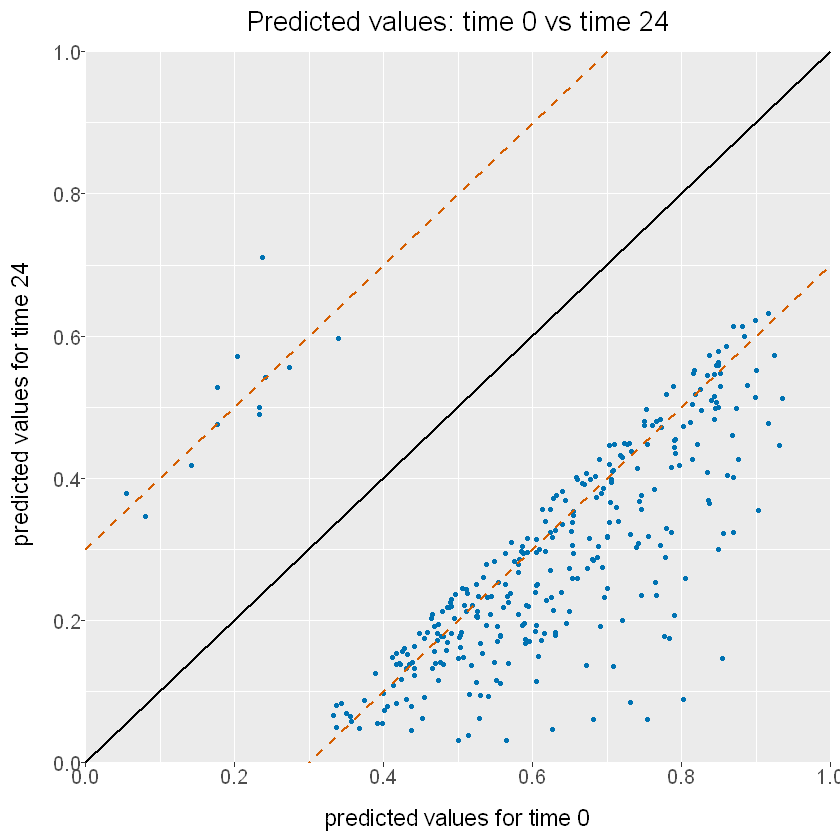

In [7]:
options(repr.plot.width=7, repr.plot.height=7)

ggplot(coh_diff, aes(x=pred_first, y=pred_death_24hr_recent)) + 
    geom_point(color = "#0072B2", size = 1) + xlim(0,1) + ylim(0,1) +
    geom_abline(intercept = 0, slope = 1, size = 0.7) +
    geom_abline(intercept = 0.3, slope = 1, size = 0.7, linetype=2, color = "#D55E00") +
    geom_abline(intercept = -0.3, slope = 1, size = 0.7, linetype=2, color = "#D55E00") +
    scale_x_continuous(name = "predicted values for time 0", expand = c(0, 0), limits=c(0, 1), 
                       breaks=c(0, 0.2, 0.4, 0.6, 0.8, 1)) + 
    scale_y_continuous(name = " predicted values for time 24", expand = c(0, 0), limits=c(0, 1), 
                       breaks=c(0, 0.2, 0.4, 0.6, 0.8, 1)) +
    theme(axis.text=element_text(size=12),
          axis.text.x = element_text(margin=margin(0, 0, 10, 0)),
          axis.text.y = element_text(margin=margin(0, 0, 0, 10)),
          plot.title = element_text(size=16, hjust=0.5, margin=margin(0, 0, 10, 0)),
          axis.title=element_text(size=14)) +
     labs(title = "Predicted values: time 0 vs time 24")


### Check most difference first
- 0.7 or more: 3
- 0.6 or more: 11
- 0.5 or more: 33

These observations include those who transferred and those who didn't.

Difference scenarios:
- 1st label != 24hr label: (transfers)
    - both predicted correctly or close enough
    - one wrong and one right
- 1st label == 24hr label: (same)
    - both predicted correctly or close enough
    - one wrong and one right
    
With the intention to check `model output differences`, all of the read-in data: 
- there is a huge difference btwn the 2 predicted outputs
- regardless whether 1st label != or == 24hr label

With the intention to investigate those who transferred, we are interested in the subgroup where *1st label != 24hr label*

Note that the same model architecture was used with 2 different labels. Binary threshold from the triage paper was 0.6

In [11]:
# count features and csn
diff <- coh_diff %>% 
            group_by(abs_diff0_24) %>% 
            summarise(nrows = n(), count_csn = n_distinct(pat_enc_csn_id_coded), count_mrn = n_distinct(anon_id)) %>% 
            arrange(-abs_diff0_24) %>% mutate(cum_csn = cumsum(count_csn))

diff

abs_diff0_24,nrows,count_csn,count_mrn,cum_csn
<dbl>,<int>,<int>,<int>,<int>
0.7,631,4,4,4
0.6,2218,10,10,14
0.5,6379,23,21,37
0.4,17906,83,82,120
0.3,42200,204,203,324


### Check those with diff >= 0.5 first:
to get some insight before expanding 

In [5]:
d05 <- coh_diff %>% filter(abs_diff0_24 >= 0.5)
length(unique(d05$pat_enc_csn_id_coded))
length(unique(d05$anon_id)) # 5 repeated anon_id
nrow(d05)
colnames(d05)

[1] 37

[1] 32

[1] 9228

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "admit_time"              "first_label"            
 [5] "death_24hr_recent_label" "death_24hr_max_label"   
 [7] "pred_first"              "pred_death_24hr_recent" 
 [9] "abs_diff0_24"            "diff0_True"             
[11] "diff24_True"             "feature_type"           
[13] "features"                "values"                 
[15] "time"                    "hr_before_admit"

### top CSNs
- top 3 vs 4 (diff >= 0.7): 131276655148, `131273666433`, 131271804263, 131265379414
- next 8 vs 10 (diff >= 0.6 and < 0.7): 
    - 131287638900, 131285560953, 131283367768, 131283156969, 131275893768, 131275001383, `131273666433`, 131273021618 (OLD)
    - 131287638900, 131285560953, 131283367768, `131278883571`, 131275001383, 131273021618, `131271881424`, `131268470191`, `131267990870`, `131266865289`

In [6]:
# top 4 csn
# as.list(distinct(coh_diff %>% filter(abs_diff0_24 >= 0.7) %>% select(pat_enc_csn_id_coded)) %>% arrange(-pat_enc_csn_id_coded))
csn1 <- sort(unique(coh_diff[coh_diff$abs_diff0_24 >= 0.7, ]$pat_enc_csn_id_coded))
csn1

# next 10 csn
csn2 <- sort(unique(coh_diff[coh_diff$abs_diff0_24 >= 0.6 &  coh_diff$abs_diff0_24 < 0.7, ]$pat_enc_csn_id_coded))
csn2

[1] 131265379414 131271804263 131273666433 131276655148

[1] 131266865289 131267990870 131268470191 131271881424 131273021618
 [6] 131275001383 131278883571 131283367768 131285560953 131287638900

In [7]:
# only 1 bad predictions on time 24. other 3 are both good on both models
top1 <- d05 %>% filter(pat_enc_csn_id_coded %in% csn1)
nrow(top1) 

top1 %>% group_by(anon_id, pat_enc_csn_id_coded) %>% summarise(n=n())
top1 %>% group_by(pat_enc_csn_id_coded) %>% select(first_label, death_24hr_recent_label,
                                                   pred_first, pred_death_24hr_recent)%>% distinct()
 
# top1 %>% distinct(pat_enc_csn_id_coded, abs_diff0_24) %>% top_n(1)

[1] 631

`summarise()` has grouped output by 'anon_id'. You can override using the `.groups` argument.



anon_id,pat_enc_csn_id_coded,n
<chr>,<dbl>,<int>
JC29fe5a7,131273666433,70
JCd1a421,131265379414,109
JCd91ab7,131271804263,236
JCe6286a,131276655148,216


Adding missing grouping variables: `pat_enc_csn_id_coded`



pat_enc_csn_id_coded,first_label,death_24hr_recent_label,pred_first,pred_death_24hr_recent
<dbl>,<int>,<int>,<dbl>,<dbl>
131276655148,1,0,0.7316375,0.08463386
131273666433,1,1,0.8026202,0.08937129
131271804263,1,0,0.8538859,0.14609018
131265379414,1,1,0.7532933,0.06092662


### Check how many were transfered:
- 19 out of 34 are from ICUs to non-ICUs
- all seem correct predictions
- anon_id `JCd91ab7` appeared 3 times
- anon_id `JCe67809` appeared 2 times

In [14]:
nrow(d05 %>% filter(first_label != death_24hr_recent_label) %>% distinct(anon_id))

d05 %>% filter(first_label != death_24hr_recent_label) %>% 
            select(anon_id, pat_enc_csn_id_coded, admit_time, first_label, death_24hr_recent_label, 
                   abs_diff0_24, pred_first, pred_death_24hr_recent) %>%
            arrange(anon_id, pat_enc_csn_id_coded) %>% distinct()# -abs_diff0_24, 

[1] 16

anon_id,pat_enc_csn_id_coded,admit_time,first_label,death_24hr_recent_label,abs_diff0_24,pred_first,pred_death_24hr_recent
<chr>,<dbl>,<dttm>,<int>,<int>,<dbl>,<dbl>,<dbl>
JC2a1b145,131267727359,2019-04-20 13:19:00,1,0,0.5,0.8695676,0.40122520
JC2a1b3e1,131265805243,2019-03-08 15:21:00,1,0,0.5,0.9311007,0.44554967
JC2a31a2b,131273021618,2019-07-01 07:21:00,1,0,0.6,0.9034398,0.35505496
JCceb298,131285560953,2020-03-06 04:21:00,1,0,0.6,0.7839395,0.17503065
JCd2b078,131281836013,2020-02-05 06:40:00,1,0,0.5,0.7208102,0.19965910
JCd3262e,131275001383,2019-08-15 16:54:00,1,0,0.6,0.8496123,0.29988991
JCd91ab7,131271804263,2019-07-11 21:43:00,1,0,0.7,0.8538859,0.14609018
JCd91ab7,131276678530,2019-10-10 03:52:00,1,0,0.5,0.7458228,0.23588984
JCd91ab7,131281472394,2020-01-16 18:22:00,1,0,0.5,0.7778456,0.28856217


### Those who did not transfer:
- 18 (out of 37): from non-ICU to ICUs
- one label prediction is wrong:  8 are for the 24hr label, 9 for time 0 label 
- If use 0.6 as the thresdhold: 1 is ambigous, JCcdbe93, but time 0 is more correct
- for those with (0,0) labels at time 0 and 24: important to investigate these 2 below
    - `JCccaf40` (131278883571) and `JCe8eecd` (131287638900) has max label of 1
    - time 0 prediction leans toward 1. 
- anon_id JC2a1b3e1 appeared 2 times

In [15]:
nrow(d05 %>% filter(first_label == death_24hr_recent_label) %>% distinct(anon_id))

d05 %>% filter(first_label == death_24hr_recent_label) %>% 
            select(anon_id, pat_enc_csn_id_coded, admit_time, first_label, death_24hr_recent_label, death_24hr_max_label,
                   abs_diff0_24, pred_first, pred_death_24hr_recent) %>%
            arrange(anon_id, pat_enc_csn_id_coded) %>% distinct() #

[1] 17

anon_id,pat_enc_csn_id_coded,admit_time,first_label,death_24hr_recent_label,death_24hr_max_label,abs_diff0_24,pred_first,pred_death_24hr_recent
<chr>,<dbl>,<dttm>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
JC29fe5a7,131273666433,2019-07-17 11:48:00,1,1,1,0.7,0.8026202,0.08937129
JC2a126ab,131275893768,2019-09-04 05:58:00,0,0,0,0.5,0.8558751,0.32251096
JC2a12b37,131267422670,2019-06-02 19:31:00,1,1,1,0.5,0.6055270,0.11430423
JC2a1b3e1,131266865289,2019-03-30 17:11:00,0,0,0,0.6,0.8695345,0.32330481
JC2a1b3e1,131271401201,2019-06-03 17:42:00,0,0,0,0.5,0.8358579,0.36825332
JCccaf40,131278883571,2019-10-31 04:28:00,0,0,1,0.6,0.8050450,0.25957323
JCcdbe93,131264937956,2019-04-14 01:08:00,1,1,1,0.5,0.5278548,0.06184646
JCd1a421,131265379414,2019-03-21 13:11:00,1,1,1,0.7,0.7532933,0.06092662
JCd21aa2,131271881424,2019-06-14 09:53:00,0,0,0,0.6,0.7077834,0.13487233


In [16]:
results05 <- d05 %>% select(anon_id, pat_enc_csn_id_coded, admit_time, first_label, death_24hr_recent_label,
                            abs_diff0_24, feature_type, features, values, time) %>% 
                    mutate(transfer = ifelse(first_label != death_24hr_recent_label, 1, 0),
                           hr_before_admit = round(as.numeric(difftime(admit_time, time, unit="hours")), 1)) %>%
                    arrange(anon_id, admit_time, -abs_diff0_24)

In [17]:
results05 %>% filter(transfer==0) %>% group_by(feature_type) %>% summarise(n=n()) %>% arrange(-n)
results05 %>% filter(transfer==0) %>% group_by(features) %>% summarise(n=n()) %>% arrange(-n) %>% head(10)

`summarise()` ungrouping output (override with `.groups` argument)



feature_type,n
<chr>,<int>
Diagnosis,1590
Meds,1105
labs,606
vitals,536
Lab,508
demo,306
Imaging,131
Procedures,45
Microbiology,7


`summarise()` ungrouping output (override with `.groups` argument)



features,n
<chr>,<int>
RR,128
Pulse,126
DBP,117
SBP,117
Temp,48
Glucose,28
Hct,20
Hgb,20
Base,19


In [18]:
results05 %>% filter(transfer==1) %>% group_by(feature_type) %>% summarise(n=n()) %>% arrange(-n)
results05 %>% filter(transfer==1) %>% group_by(features) %>% summarise(n=n()) %>% arrange(-n) %>% head(10)

`summarise()` ungrouping output (override with `.groups` argument)



feature_type,n
<chr>,<int>
Diagnosis,1391
labs,863
Meds,810
vitals,589
Lab,349
demo,323
Imaging,43
Procedures,23
Microbiology,3


`summarise()` ungrouping output (override with `.groups` argument)



features,n
<chr>,<int>
Pulse,136
DBP,134
SBP,134
RR,133
Glucose,58
Temp,52
K,39
Na,37
Hct,33


In [19]:
results05 %>% group_by(feature_type) %>% summarise(n=n()) %>% arrange(-n)
results05 %>% group_by(features) %>% summarise(n=n()) %>% arrange(-n) %>% head(10)

`summarise()` ungrouping output (override with `.groups` argument)



feature_type,n
<chr>,<int>
Diagnosis,2981
Meds,1915
labs,1469
vitals,1125
Lab,857
demo,629
Imaging,174
Procedures,68
Microbiology,10


`summarise()` ungrouping output (override with `.groups` argument)



features,n
<chr>,<int>
Pulse,262
RR,261
DBP,251
SBP,251
Temp,100
Glucose,86
K,57
Na,55
Hct,53


,anon_id,pat_enc_csn_id_coded,admit_time,first_label,death_24hr_recent_label,abs_diff0_24,feature_type,features,values,time,transfer,hr_before_admit
,<chr>,<dbl>,<dttm>,<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>
1,JC29fe5a7,131273666433,2019-07-17 11:48:00,1,1,0.7,vitals,Temp,36.8,2019-07-17 08:34:00,0,3.2
2,JC29fe5a7,131273666433,2019-07-17 11:48:00,1,1,0.7,vitals,DBP,94.0,2019-07-17 08:34:00,0,3.2
3,JC29fe5a7,131273666433,2019-07-17 11:48:00,1,1,0.7,vitals,Pulse,107.0,2019-07-17 08:34:00,0,3.2
4,JC29fe5a7,131273666433,2019-07-17 11:48:00,1,1,0.7,vitals,RR,22.0,2019-07-17 08:34:00,0,3.2
5,JC29fe5a7,131273666433,2019-07-17 11:48:00,1,1,0.7,vitals,SBP,132.0,2019-07-17 08:34:00,0,3.2
6,JC29fe5a7,131273666433,2019-07-17 11:48:00,1,1,0.7,vitals,Temp,37.0,2019-07-17 08:34:00,0,3.2


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   0.900   1.700   1.933   2.800   6.500    6634 

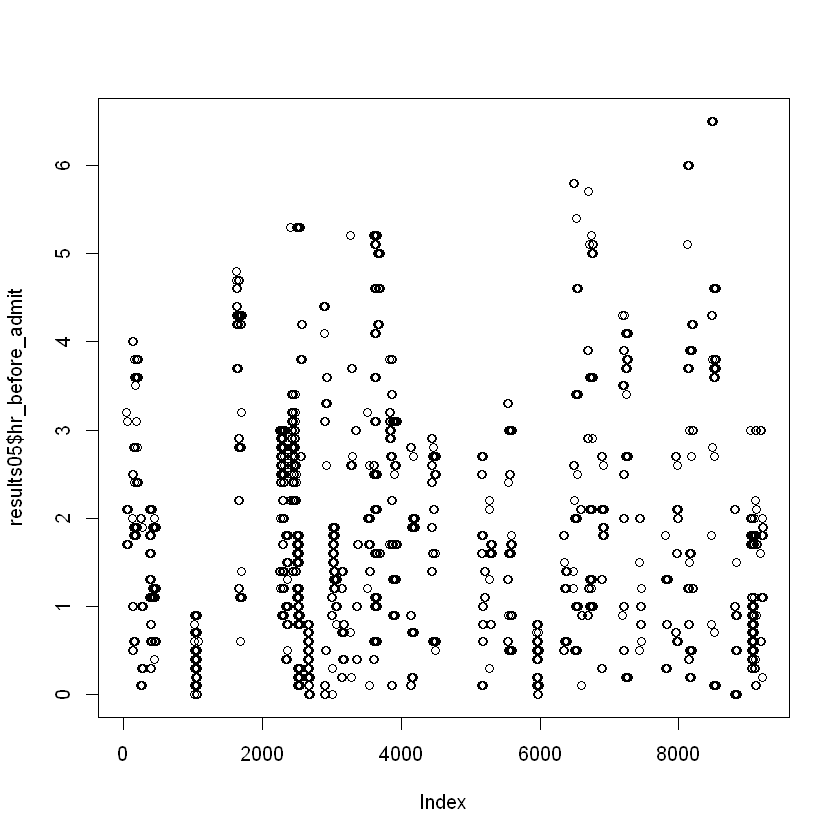

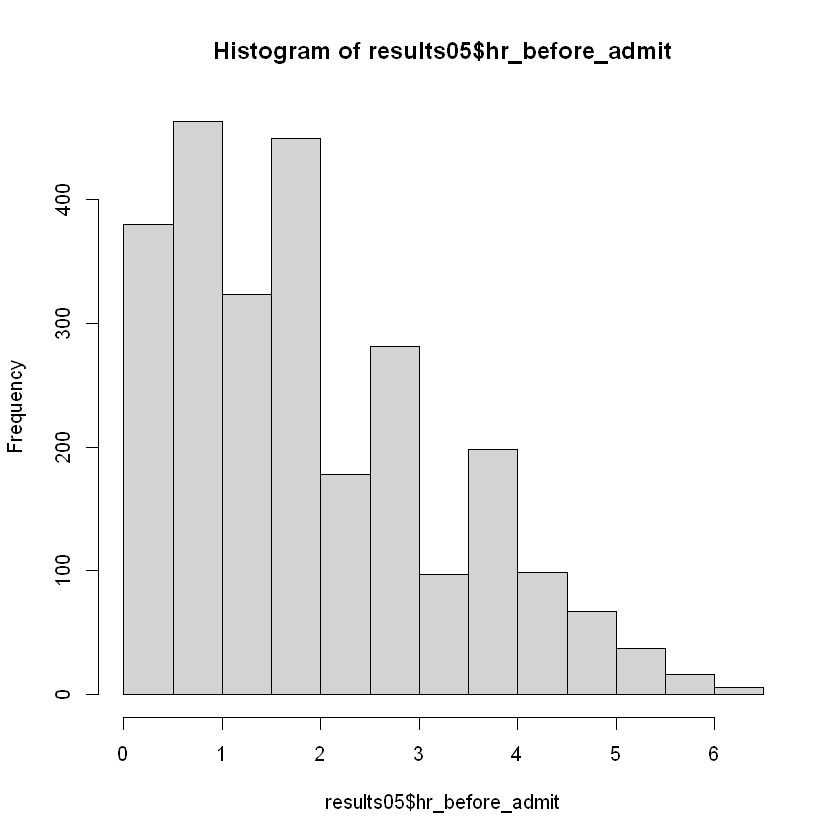

In [20]:
head(results05 %>% filter(feature_type == 'vitals'))
summary(results05$hr_before_admit)
plot(results05$hr_before_admit)
hist(results05$hr_before_admit)

In [21]:
results05_vsglu <- results05 %>% filter(feature_type=='vitals' | features=="Glucose") %>%
                    group_by(pat_enc_csn_id_coded, features, hr_before_admit) %>%
                    summarise(values=mean(values, na.rm=TRUE)) %>%
                    mutate(pat_enc_csn_id_coded = factor(pat_enc_csn_id_coded),
                           features = factor(features))
results05_vsglu %>% group_by(features) %>% summarise(n=n()) %>% arrange(-n)
head(results05_vsglu, 1)

`summarise()` regrouping output by 'pat_enc_csn_id_coded', 'features' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



features,n
<fct>,<int>
Pulse,224
RR,222
DBP,216
SBP,216
Glucose,83
Temp,52


pat_enc_csn_id_coded,features,hr_before_admit,values
<fct>,<fct>,<dbl>,<dbl>
131263398448,DBP,0,78


Warning message:
"`fun.y` is deprecated. Use `fun` instead."
`geom_smooth()` using method = 'loess' and formula 'y ~ x'



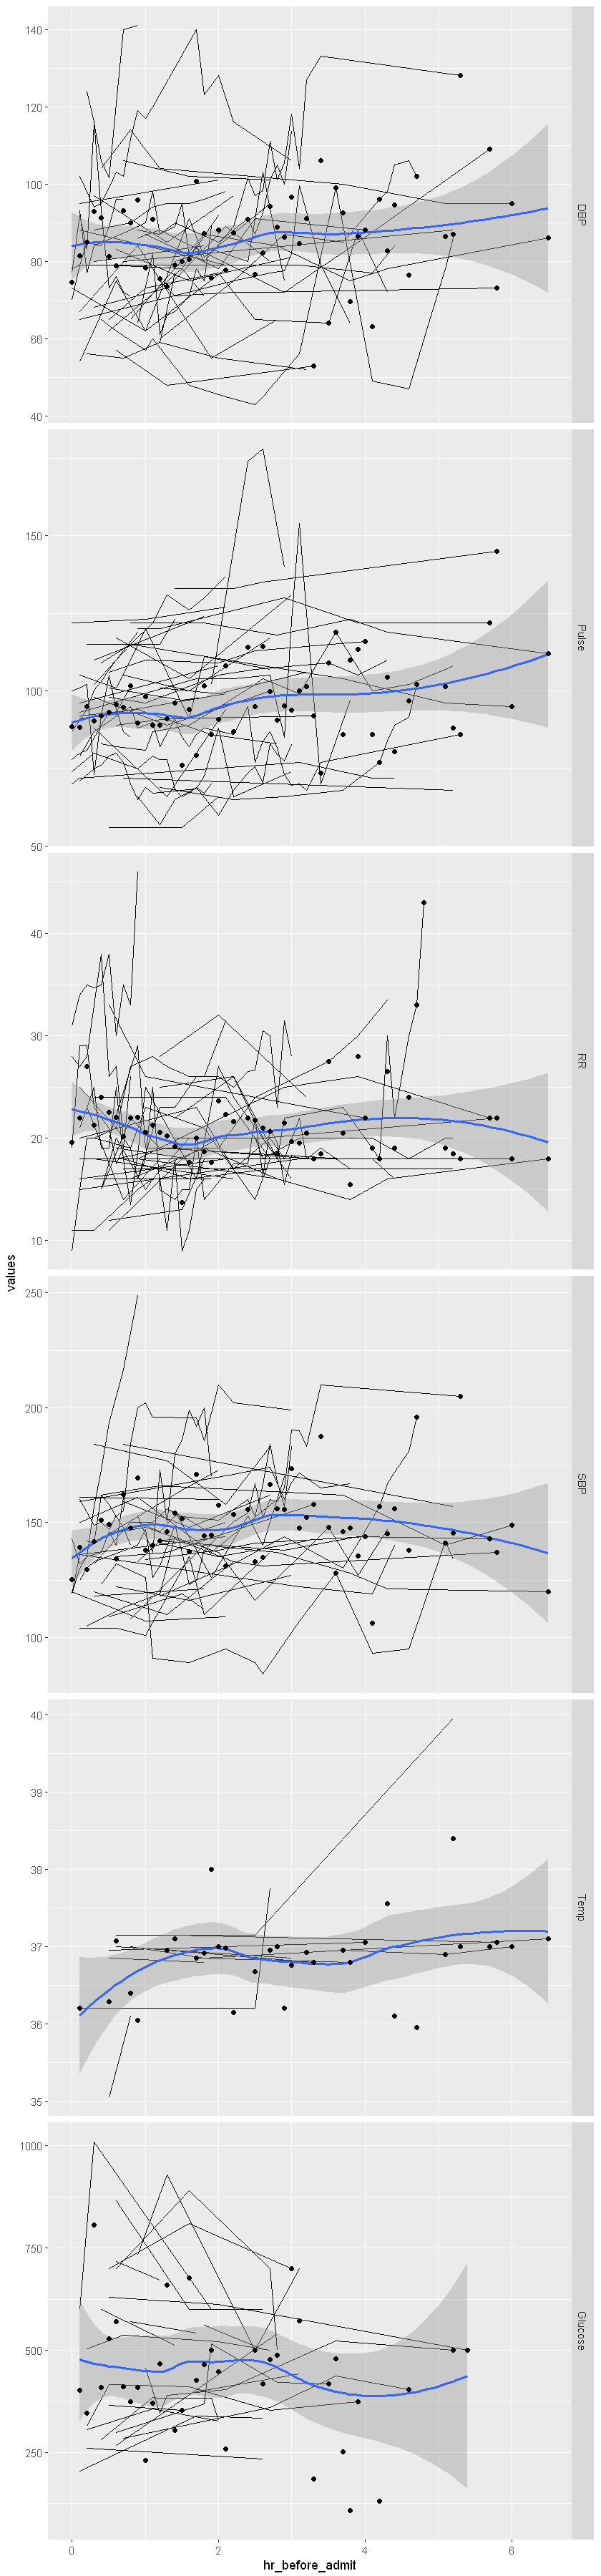

In [22]:
options(repr.plot.width=7, repr.plot.height=30)

# p <- ggplot(data = results05_vs, aes(x = hr_before_admit, y = values, group = pat_enc_csn_id_coded)) + facet_grid(. ~ features)
# facet_wrap(. ~ features, scales="free_y") # cannot do facet_grid with free scale as above
p <- ggplot(data = results05_vsglu, aes(x = hr_before_admit, y = values, group = pat_enc_csn_id_coded)) + facet_grid(features ~ ., scales="free")

# use group 1 as for the whole data NOT per csn: so the smooth is not calculated separately for each csn
p + geom_line() + stat_smooth(aes(group = 1)) + stat_summary(aes(group = 1), geom = "point", fun.y = mean)

In [42]:
# results05 wide<- spread(results05, features, values)

### First obs:
- CSN: 131265379414
- first_label = death_24hr_recent_label = 1
- pred_first = 0.796905; pred_death_24hr_recent = 0.06790455 vs  0.7532933 & 0.06092662

### Check ADT table:

In [9]:
adt <- read.csv(file.path(datadir, 'adt_class_serv_loc.csv'))

In [10]:
head(adt)

,pat_class_c,pat_class,base_pat_class,pat_service,pat_lv_of_care
,<int>,<chr>,<chr>,<chr>,<chr>
1,120,LPCH PATIENT,,Emergency Medicine,
2,166,Bedded Outpatient (corrections only),,Emergency,
3,166,Bedded Outpatient (corrections only),Outpatient,Emergency,Acute Care (Assessment or intervention q4-8)
4,166,Bedded Outpatient (corrections only),,Emergency,Acute Care (Assessment or intervention q4-8)
5,132,To Be Admitted,Inpatient,Emergency,
6,166,Bedded Outpatient (corrections only),,Emergency,Acute Care (Assessment or intervention q4-8)


### Investigate:
1. Diagnosis
2. Medications
3. Vital trend
4. Lab trend, esp. glucose
5. ADT trajectories, team (Tiffany)
6. Demographics (Tiffany)